In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import colors
from datetime import date

# Downloading and Formatting Data

In [2]:
#Weather station IDs used by Tonga MET website
station_ids = {
        'Vavau':3,
        'Tongatapu':1
}
print(station_ids.keys())

dict_keys(['Vavau', 'Tongatapu'])


In [3]:
#Base pieces of URL to request data from Tonga MET server
# EXAMPLE: http://met.gov.to:2016/weather_analysis.do?stationId=3&timeType=1&date=09/03/2019%20-%2009/10/2019
# split the above into pieces and change only the varable elements (weather stations, date range)
base_url = 'http://met.gov.to:2016/weather_analysis_excel.do?stationId='
mid_url = '&timeType=1&date=01/01/1980%20-%20'

#Formatting date to use in web query & for excel file name
today = date.today()
end_date = str(today.month).zfill(2)+'/'+str(today.day).zfill(2)+'/'+str(today.year)
end_date_filename = str(today.month).zfill(2)+str(today.day).zfill(2)+str(today.year)

In [4]:
#Downloading data and writing to local disk
for station in station_ids.keys():
    # Downloading data from MET & handling missing values
    url = base_url+str(station_ids[station])+mid_url+end_date
    df = pd.read_excel(url).fillna(np.nan)
    df = df.replace(-999,np.nan)
    # Formatting timestamp for aggregations
    df['Time']    = pd.to_datetime(df['Time'])
    df['Year']    = df['Time'].dt.year
    df['Month']   = df['Time'].dt.month
    df['Week']    = df['Time'].dt.week
    df['Phenophase'] = pd.cut(df['Month'],[-1,6,8,11,15], labels=['No Flower','Pre-Onset','Flowering','NF'])
    df['Phenophase'] = df['Phenophase'].replace({'NF':'No Flower'})
    # set temp variables
    tmin = df[df.columns[2]]
    tmax = df[df.columns[3]]
    # Calculating degree day indicators
    df['Delta']   = tmax-tmin
    df['DD_over25']  = tmax.clip(lower=25).multiply(0.5)+tmin.clip(lower=25).multiply(0.5)-25
    df['DD_over30'] = tmax.clip(lower=30).multiply(0.5)+tmin.clip(lower=30).multiply(0.5)-30
    df['DD_under20']= 20-tmax.clip(upper=20).multiply(0.5)-tmin.clip(upper=20).multiply(0.5)
    df['DD_under18']= 18-tmax.clip(upper=18).multiply(0.5)-tmin.clip(upper=18).multiply(0.5)
    # Writing data to disk as excel file
    df.to_excel(station+'-01011980 to '+end_date_filename+'.xls')
    print(station, url)

Vavau http://met.gov.to:2016/weather_analysis_excel.do?stationId=3&timeType=1&date=01/01/1980%20-%2009/18/2019
Tongatapu http://met.gov.to:2016/weather_analysis_excel.do?stationId=1&timeType=1&date=01/01/1980%20-%2009/18/2019


# Defining parameters and titles for weekly heatmaps

In [5]:
figure_dict = {
    'min_temp':{
        'min_val':17,
        'max_val':27, 
        'name':'mean minimum temperature (C)',
        'df_column':str(df.columns[2]), 
        'color':'coolwarm'
    },
    'max_temp':{
        'min_val':22, 
        'max_val':32, 
        'name':'mean maximum temperature (C)', 
        'df_column':str(df.columns[3]), 
        'color':'coolwarm'
    },
    'mean_rain':{
        'min_val':0, 
        'max_val':75, 
        'name':'mean weekly rainfall(mm)',
        'df_column':str(df.columns[6]), 
        'color':'Blues'
    },
    'Delta':{
        'min_val':0, 
        'max_val':12, 
        'name':'mean temperature Spread (C)', 
        'df_column':'Delta', 
        'color':'Blues'
    },
    'DD_over25':{
        'min_val':0, 
        'max_val':5, 
        'name':'mean degree days over 25C', 
        'df_column':'DD_over25', 
        'color':'YlOrRd'
    },
    'DD_over30':{
        'min_val':0, 
        'max_val':2, 
        'name':'mean degree days over 30C', 
        'df_column':'DD_over30', 
        'color':'YlOrRd'
    },
    'DD_under20':{
        'min_val':0, 
        'max_val':2, 
        'name':'mean degree days under 20C', 
        'df_column':'DD_under20', 
        'color':'Blues'
    },
    'DD_under18':{
        'min_val':0, 
        'max_val':2, 
        'name':'mean degree days under 18C', 
        'df_column':'DD_under18', 
        'color':'Blues'
    }
}

# Weekly Heatmaps

Vavau - weekly mean minimum temperature (C)


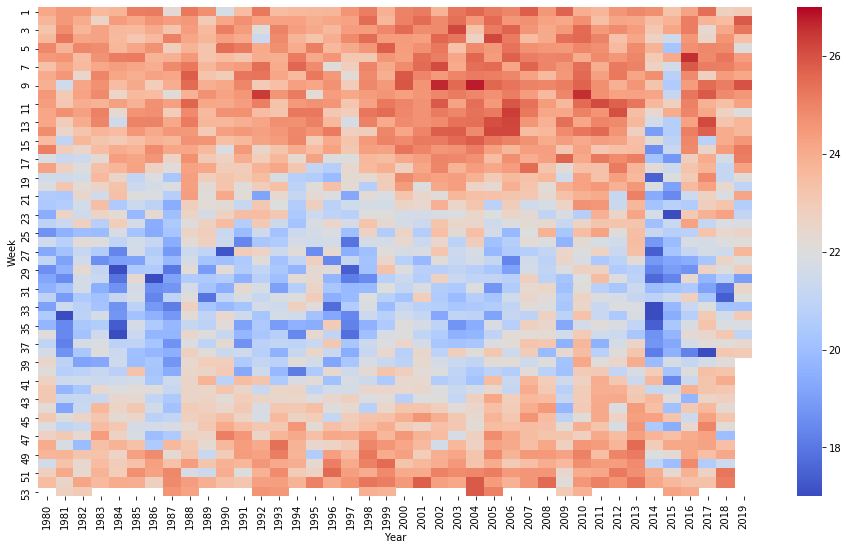

Vavau - weekly mean maximum temperature (C)


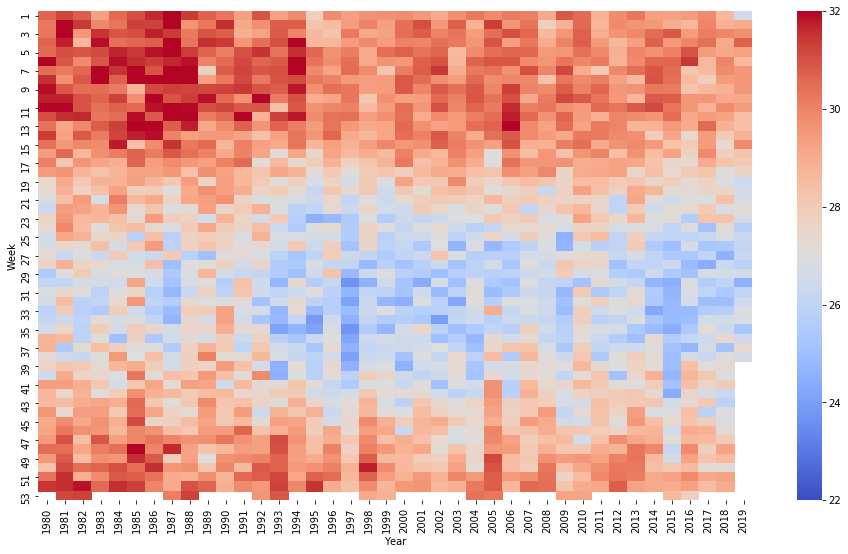

Vavau - weekly mean weekly rainfall(mm)


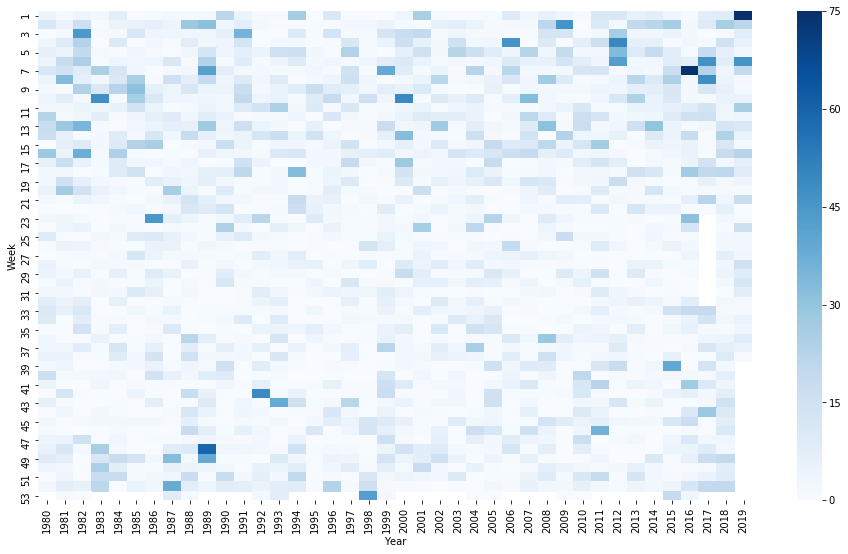

Vavau - weekly mean temperature Spread (C)


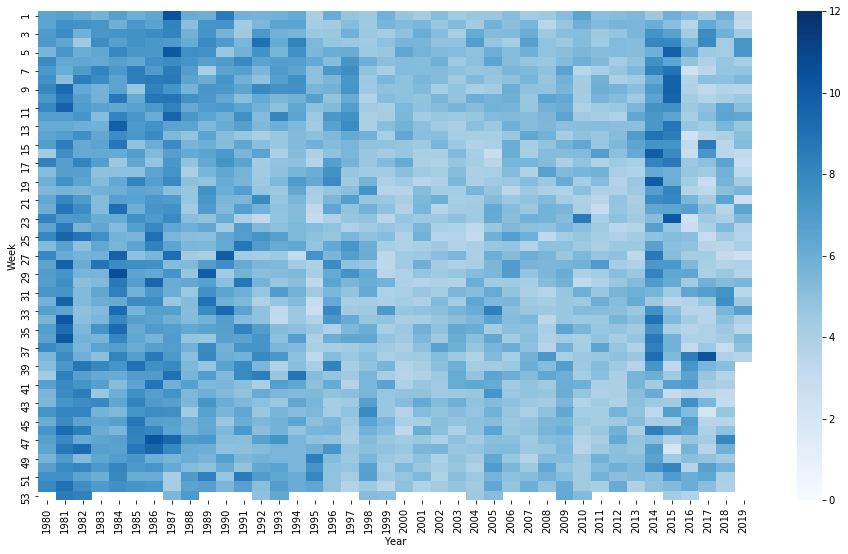

Vavau - weekly mean degree days over 25C


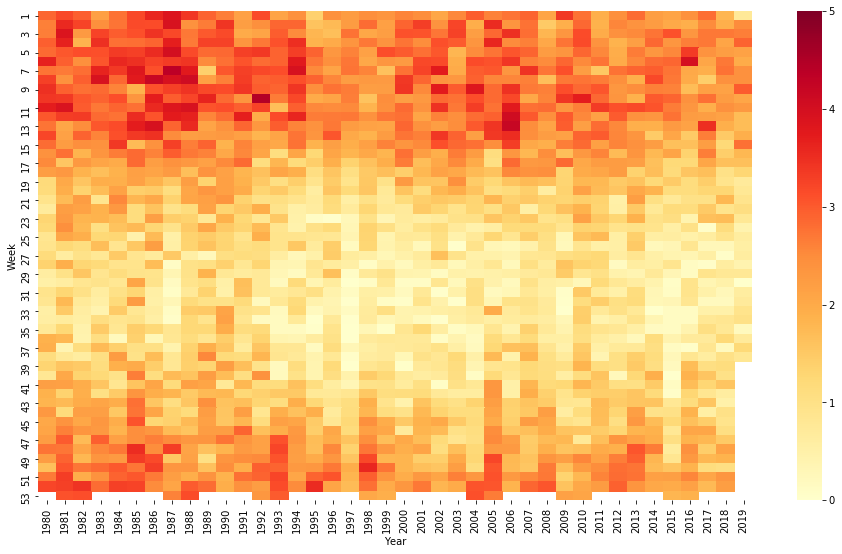

Vavau - weekly mean degree days over 30C


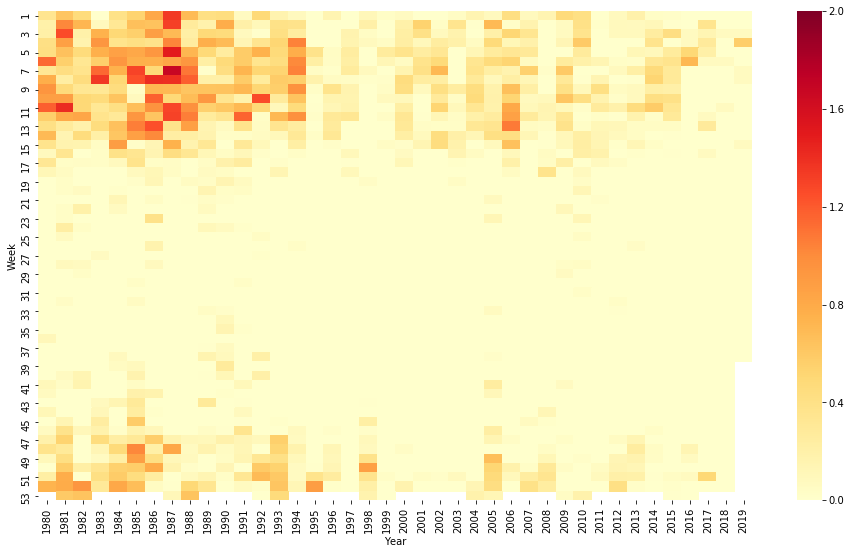

Vavau - weekly mean degree days under 20C


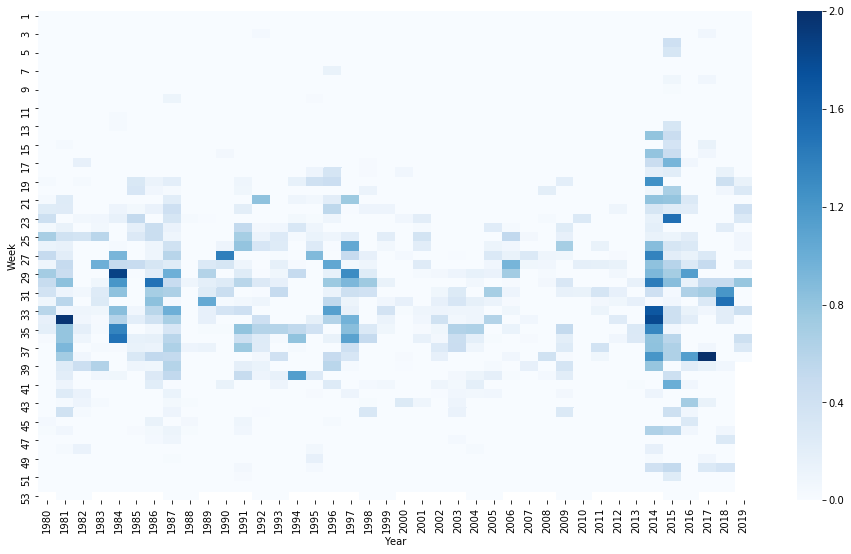

Vavau - weekly mean degree days under 18C


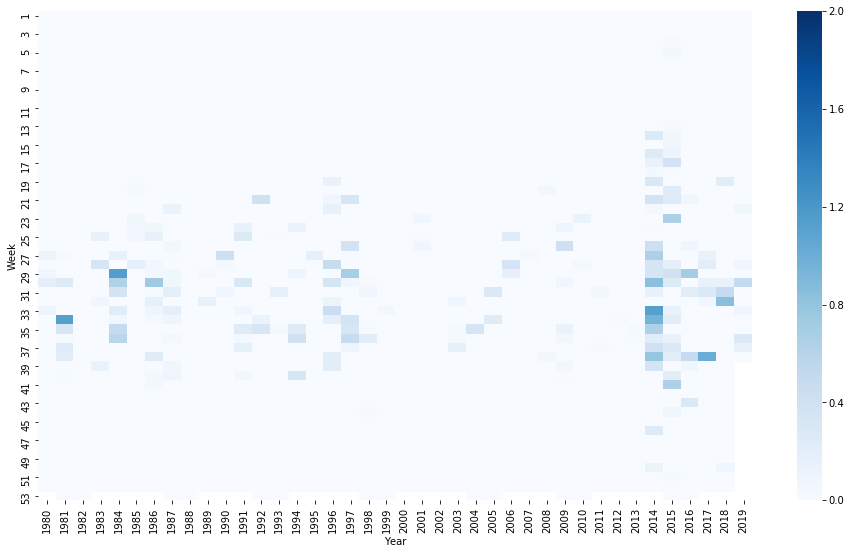

Tongatapu - weekly mean minimum temperature (C)


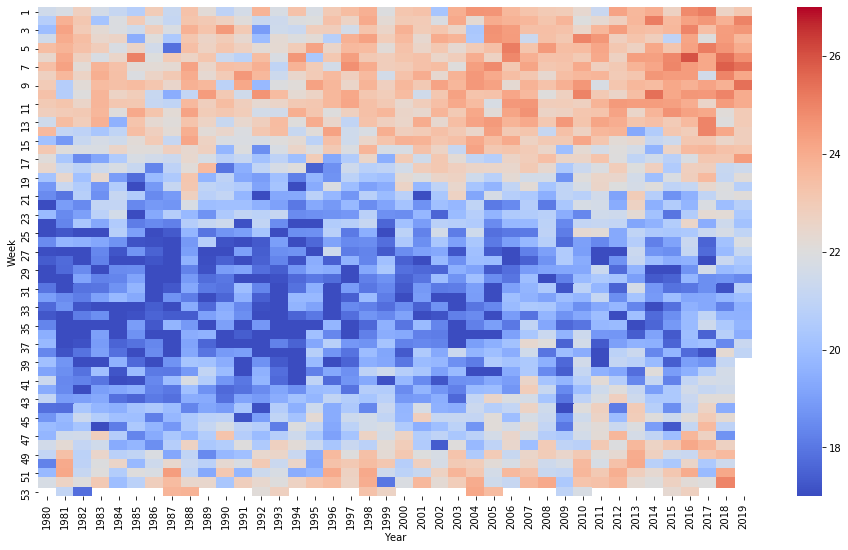

Tongatapu - weekly mean maximum temperature (C)


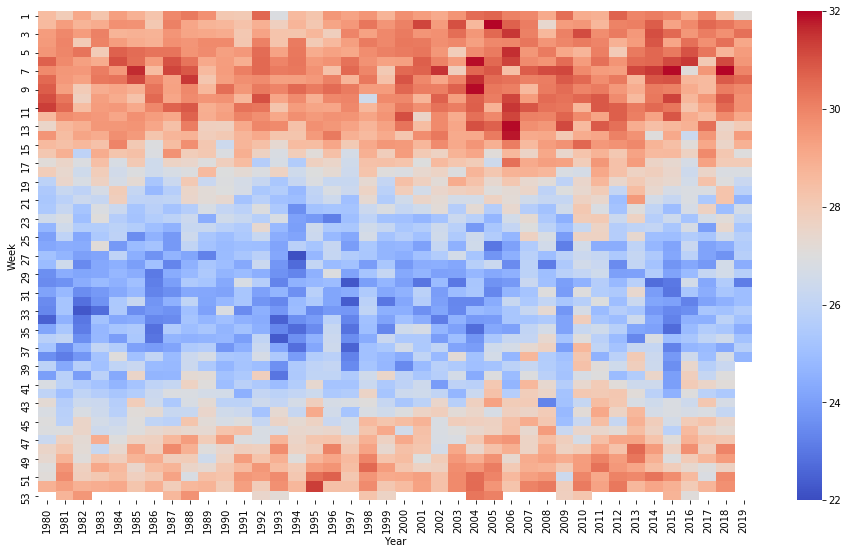

Tongatapu - weekly mean weekly rainfall(mm)


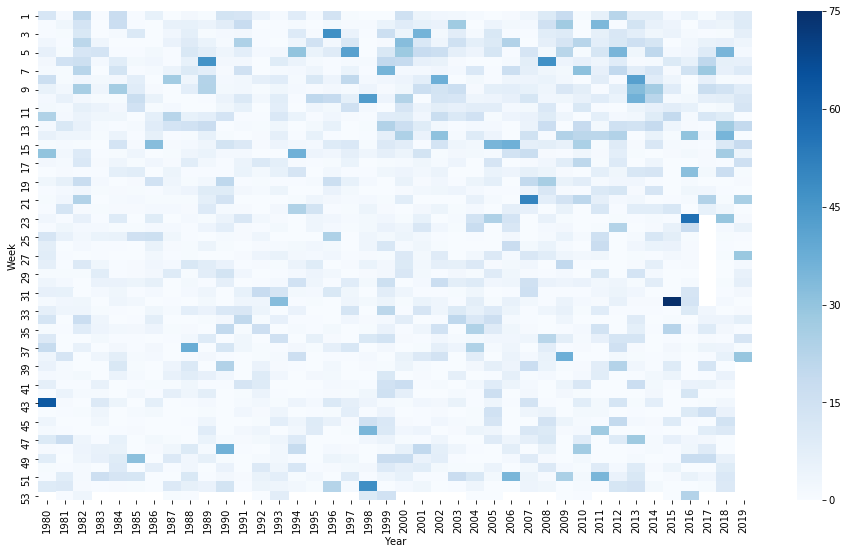

Tongatapu - weekly mean temperature Spread (C)


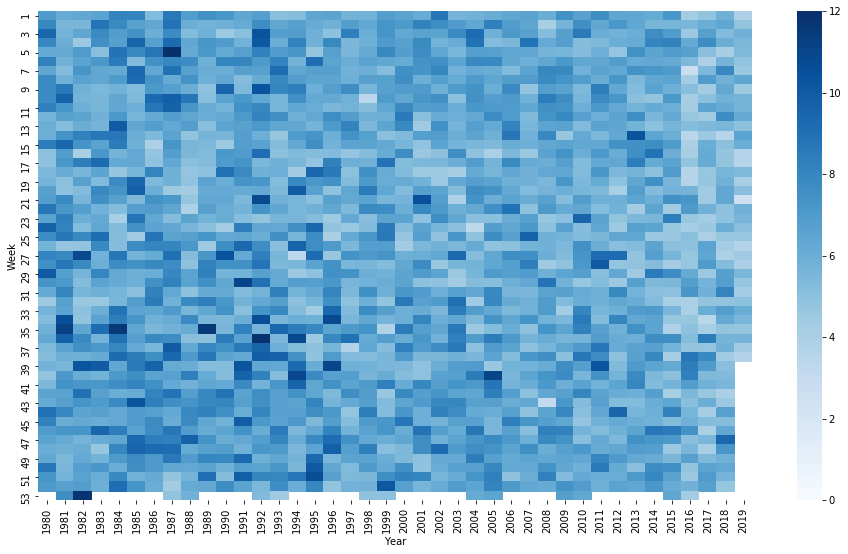

Tongatapu - weekly mean degree days over 25C


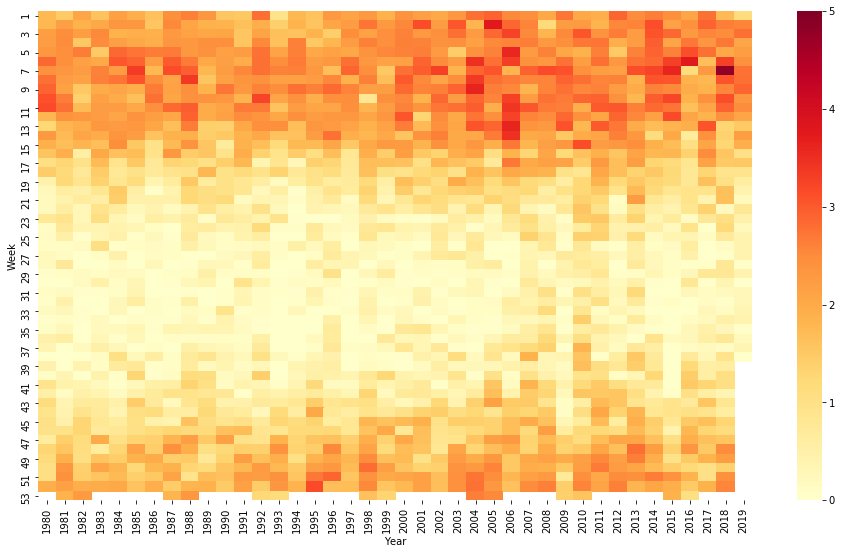

Tongatapu - weekly mean degree days over 30C


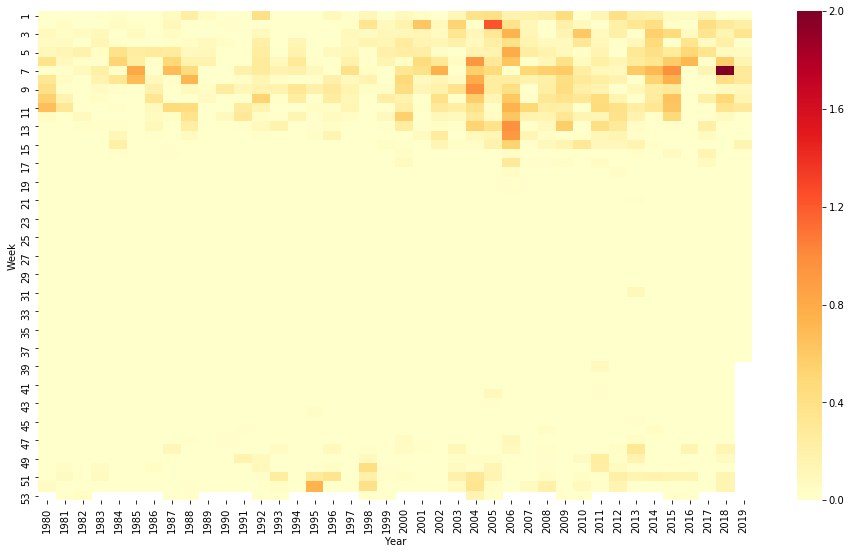

Tongatapu - weekly mean degree days under 20C


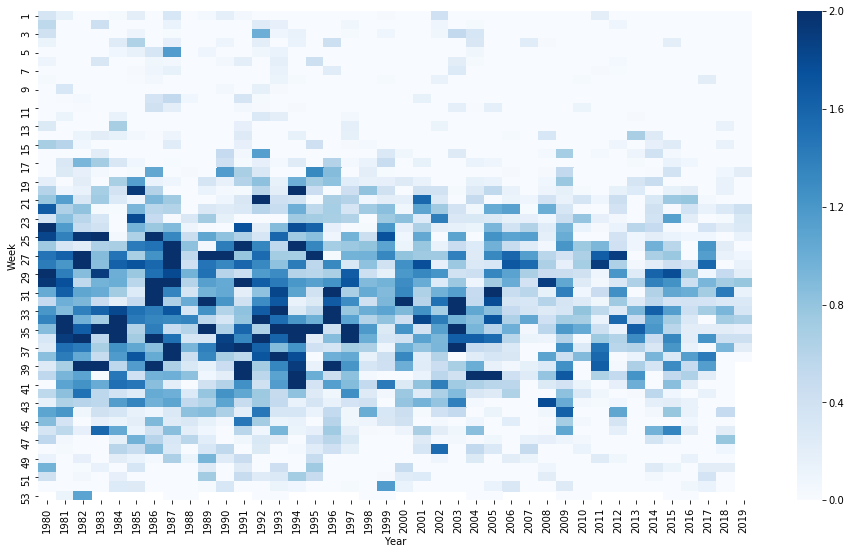

Tongatapu - weekly mean degree days under 18C


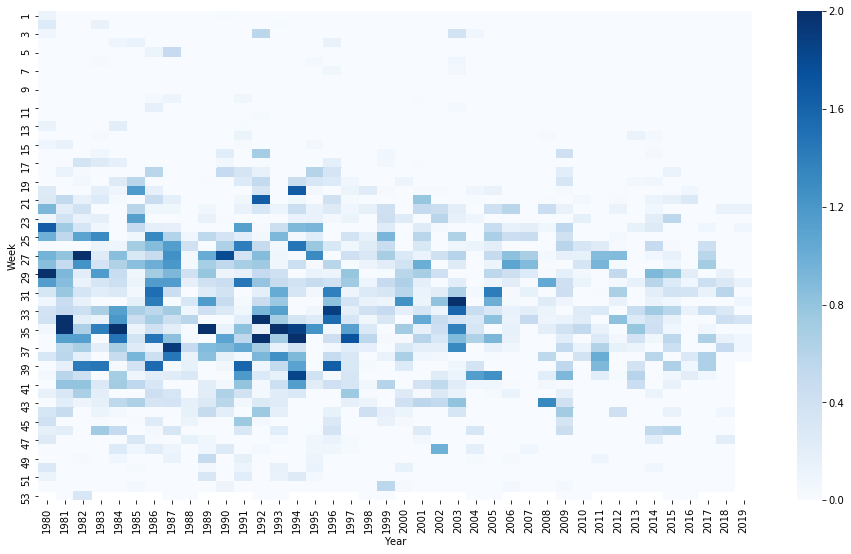

In [6]:
for station in station_ids.keys():
    #Read excel file into memory
    frame = pd.read_excel(station+'-01011980 to '+end_date_filename+'.xls', header=0).fillna(np.nan)
    #Generating heatmaps
    for figure in figure_dict.keys():
        htmp = pd.pivot_table(
            frame,index='Week',
            columns='Year',
            values = figure_dict[figure]['df_column'],
            aggfunc=np.mean
        )
        fig, ax = plt.subplots(figsize=(16,9))
        sns.heatmap(
            htmp,
            vmin = figure_dict[figure]['min_val'],
            vmax = figure_dict[figure]['max_val'],
            cmap=figure_dict[figure]['color']
        )
        print(station+' - weekly '+figure_dict[figure]['name'])
        plt.show()

# Phenophase Heatmaps

In [7]:
# Redefining max_value ranges for select variables
figure_dict['DD_over25']['max_val']=3
figure_dict['DD_over30']['max_val']=0.7
figure_dict['DD_under20']['max_val']=1
figure_dict['DD_under18']['max_val']=0.8
figure_dict['mean_rain']['max_val']=15

Vavau - phase mean minimum temperature (C)


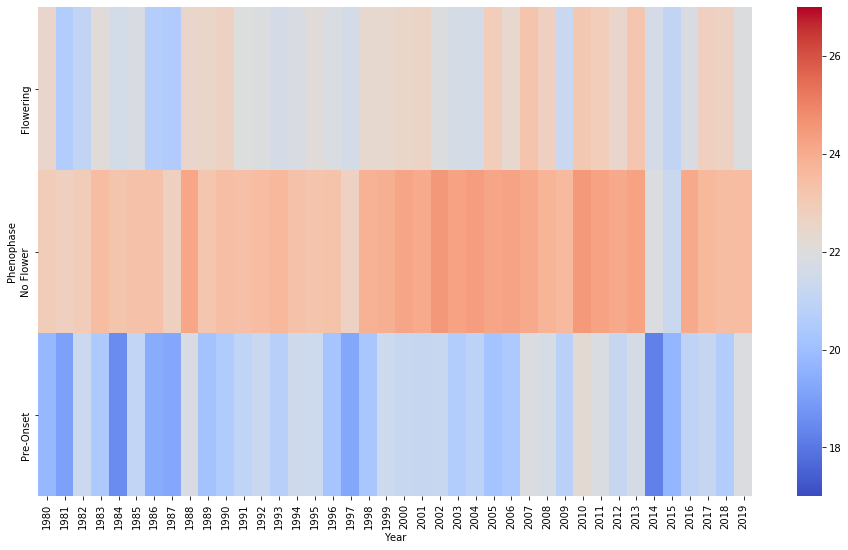

Vavau - phase mean maximum temperature (C)


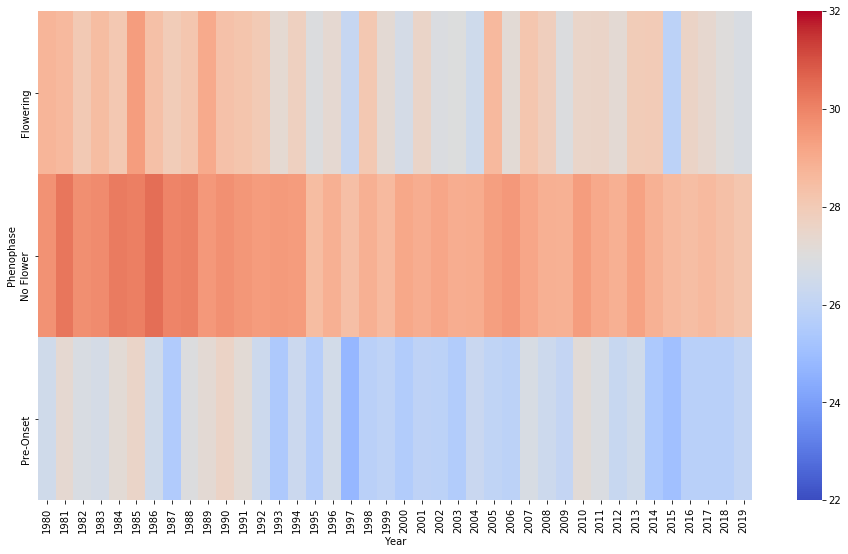

Vavau - phase mean weekly rainfall(mm)


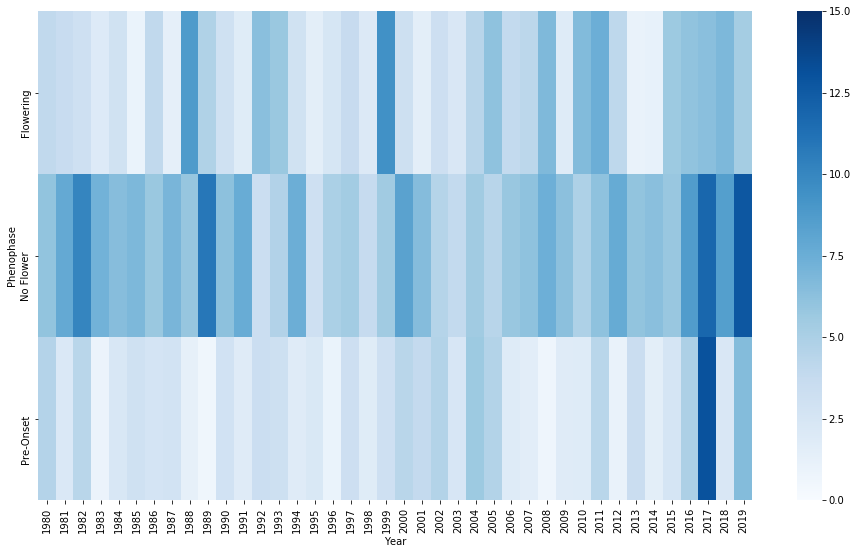

Vavau - phase mean temperature Spread (C)


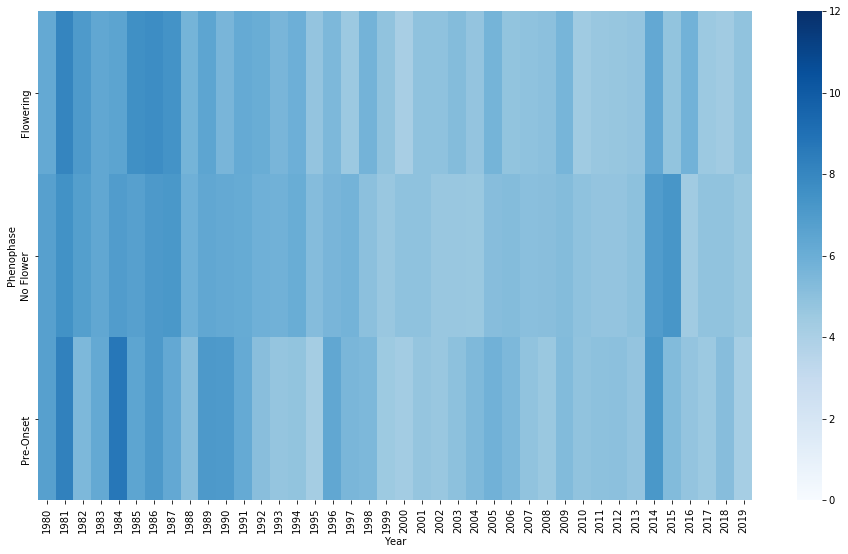

Vavau - phase mean degree days over 25C


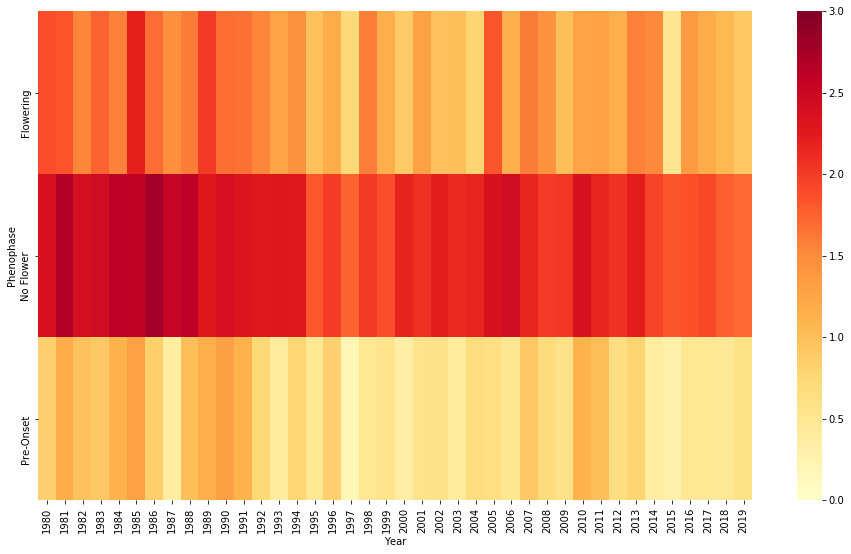

Vavau - phase mean degree days over 30C


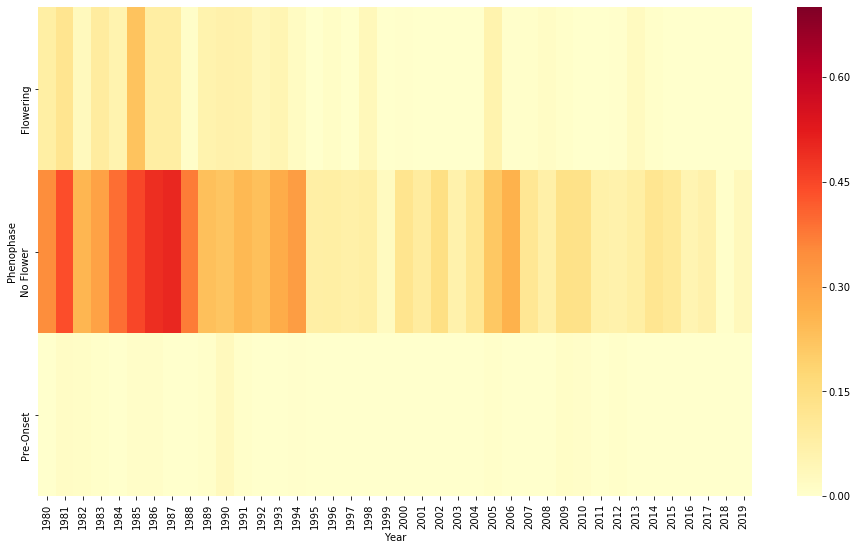

Vavau - phase mean degree days under 20C


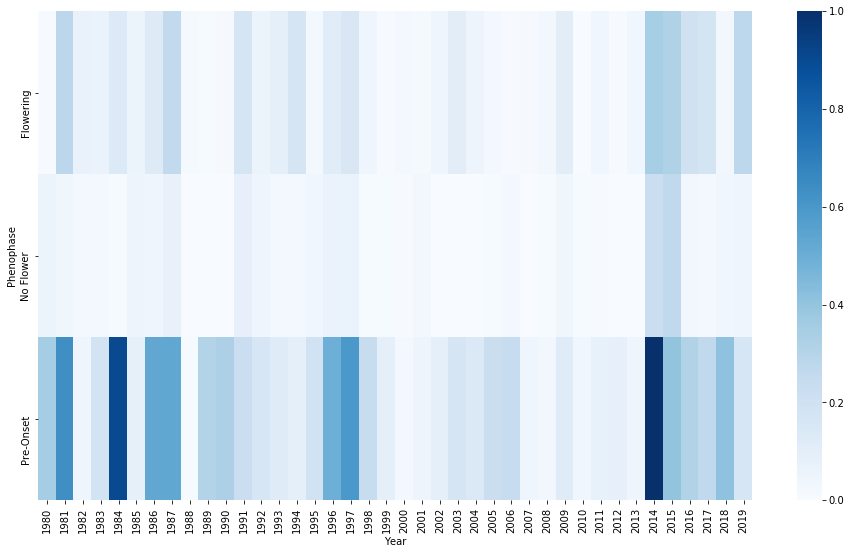

Vavau - phase mean degree days under 18C


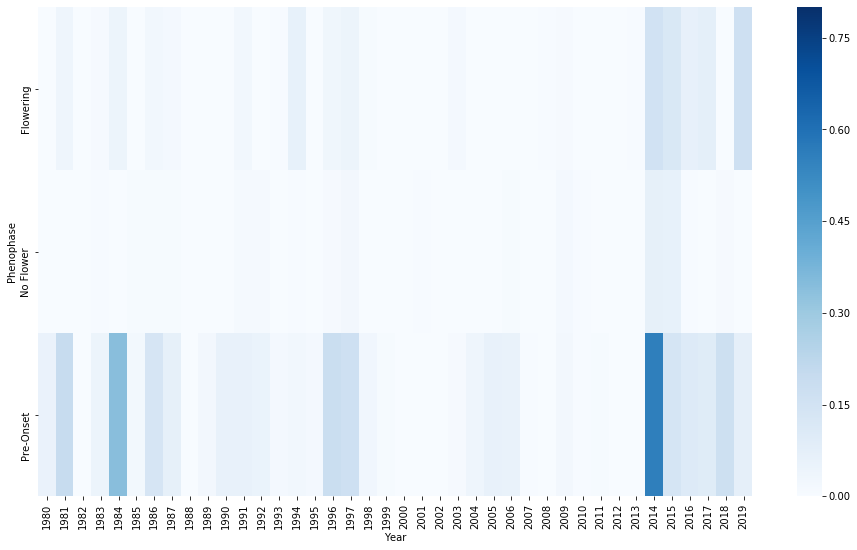

Tongatapu - phase mean minimum temperature (C)


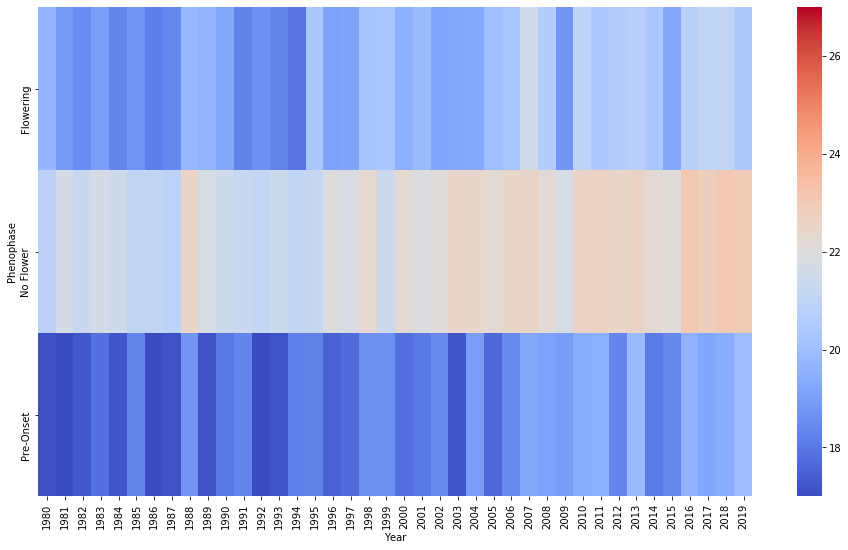

Tongatapu - phase mean maximum temperature (C)


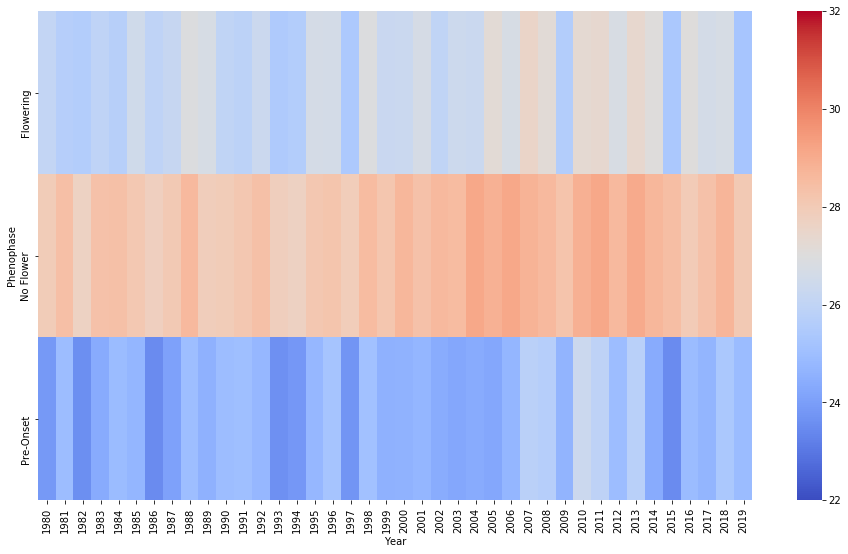

Tongatapu - phase mean weekly rainfall(mm)


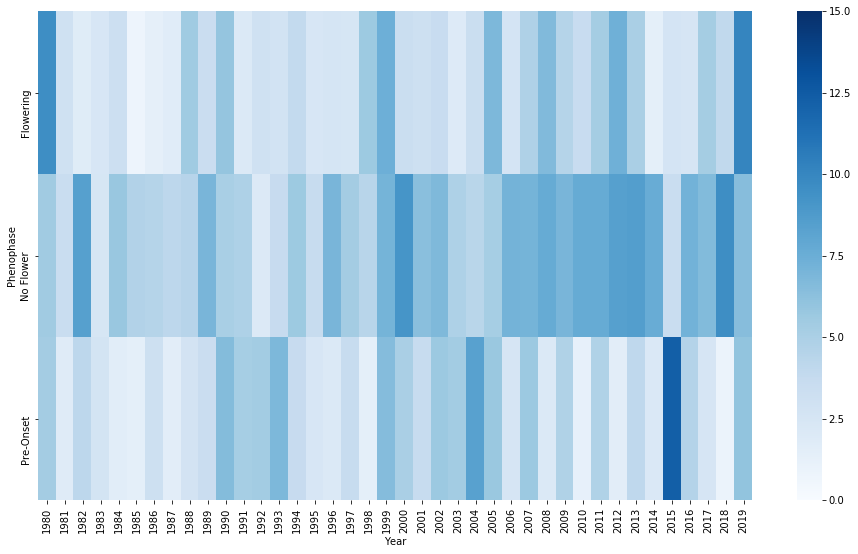

Tongatapu - phase mean temperature Spread (C)


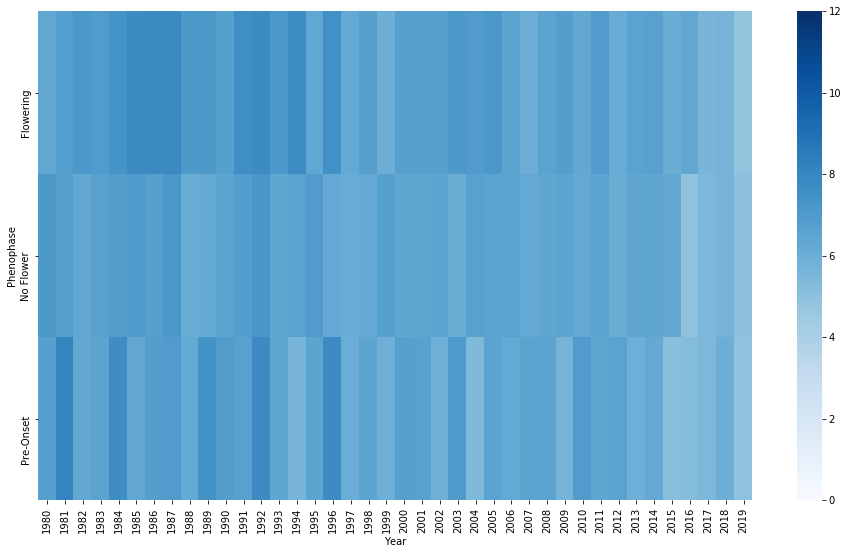

Tongatapu - phase mean degree days over 25C


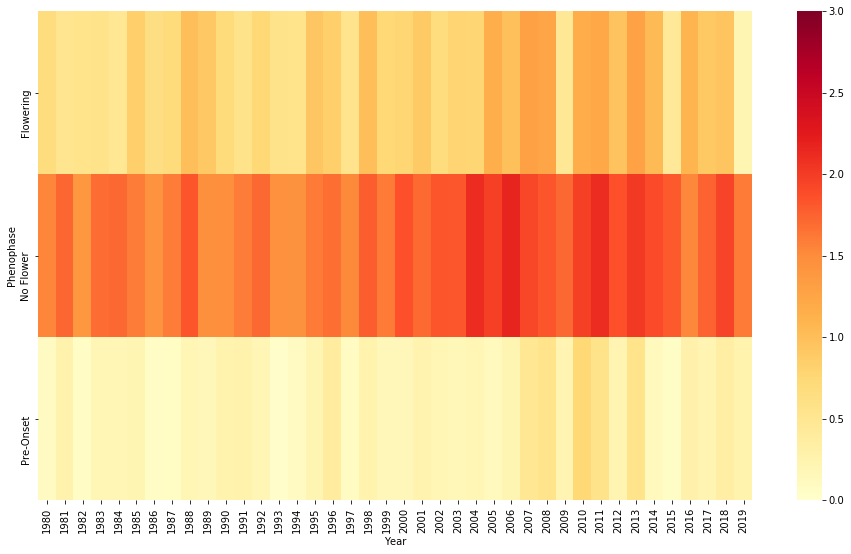

Tongatapu - phase mean degree days over 30C


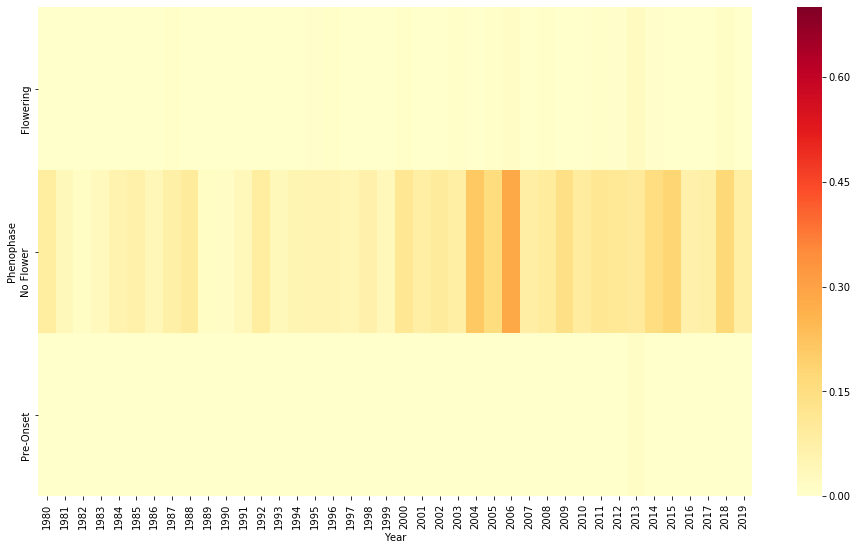

Tongatapu - phase mean degree days under 20C


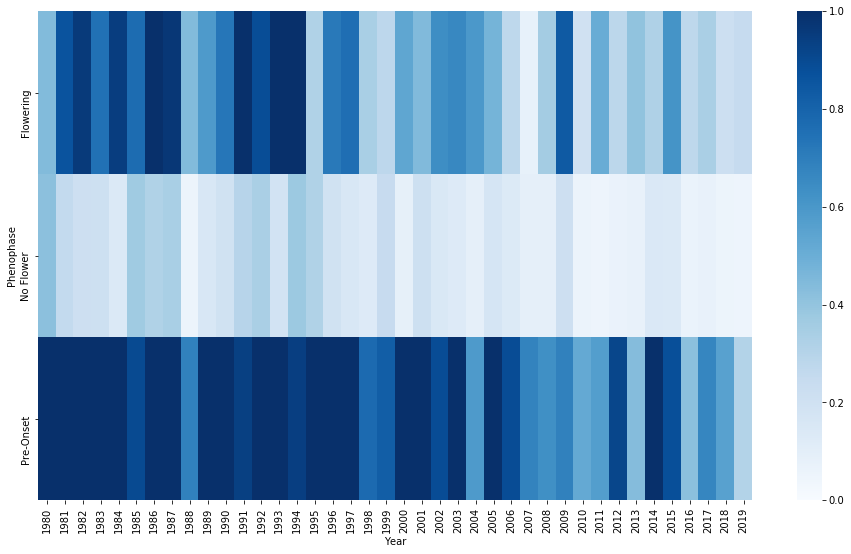

Tongatapu - phase mean degree days under 18C


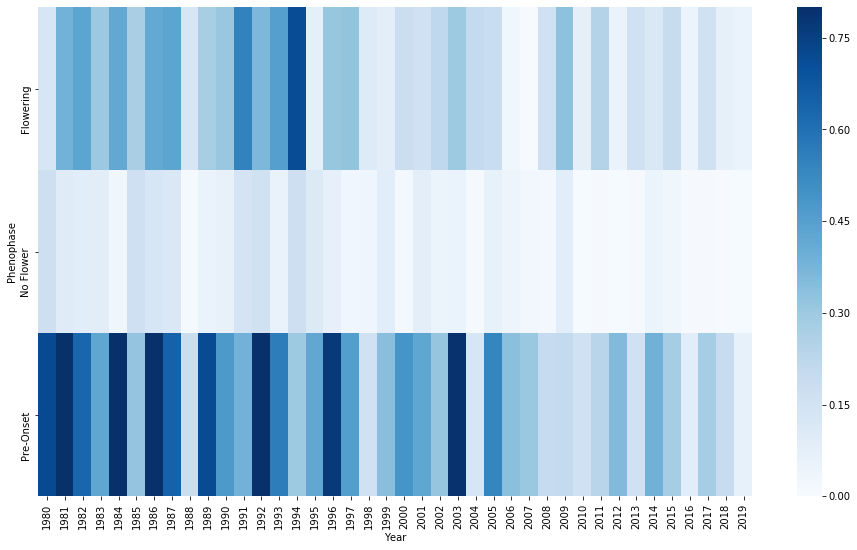

In [8]:
#Generating figures and writing to disk as PNG files
for station in station_ids.keys():
    #Read excel file into memory
    frame = pd.read_excel(station+'-01011980 to '+end_date_filename+'.xls', header=0).fillna(np.nan)
    #Generating heatmaps
    for figure in figure_dict.keys():
        table_sum = pd.pivot_table(frame,index='Phenophase',columns='Year',values = figure_dict[figure]['df_column'],aggfunc=np.sum)
        table_sum.to_excel(station+' - '+figure_dict[figure]['name']+' by phenophase.xls')
        htmp = pd.pivot_table(frame,index='Phenophase',columns='Year',values = figure_dict[figure]['df_column'],aggfunc=np.mean)
        fig, ax = plt.subplots(figsize=(16,9))
        sns.heatmap(htmp,vmin = figure_dict[figure]['min_val'], vmax = figure_dict[figure]['max_val'], cmap=figure_dict[figure]['color'])
        print(station+' - phase '+figure_dict[figure]['name'])
        plt.show()

# Heatmaps by Growing Season Phases

In [9]:
phases = {
    'tiptop':[18,32,False],
    'preonset':[20,36,False],
    'pollination':[36,48,False],
    'harvest':[13,32,False],
    'podfill':[36,13,True]
}

Vavau - mean minimum temperature (C) - tiptop months18 - 32


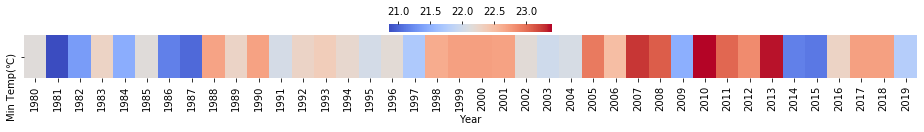

Vavau - mean maximum temperature (C) - tiptop months18 - 32


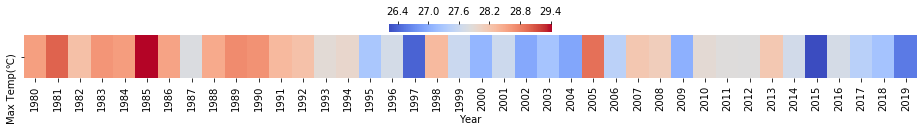

Vavau - mean weekly rainfall(mm) - tiptop months18 - 32


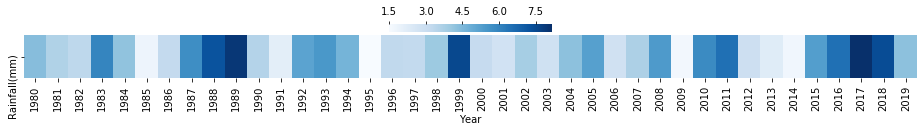

Vavau - mean temperature Spread (C) - tiptop months18 - 32


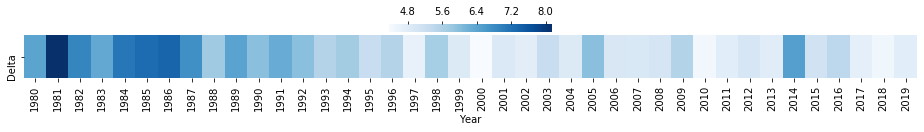

Vavau - mean degree days over 25C - tiptop months18 - 32


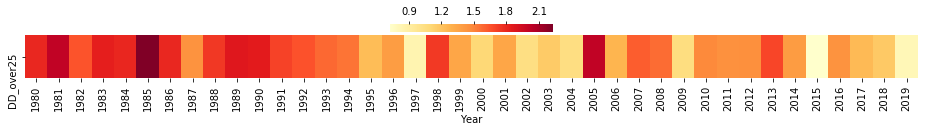

Vavau - mean degree days over 30C - tiptop months18 - 32


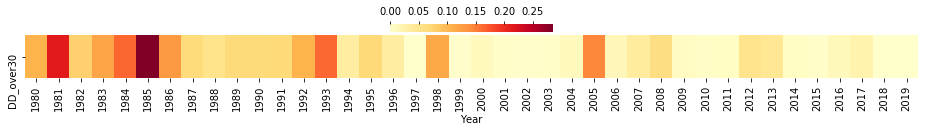

Vavau - mean degree days under 20C - tiptop months18 - 32


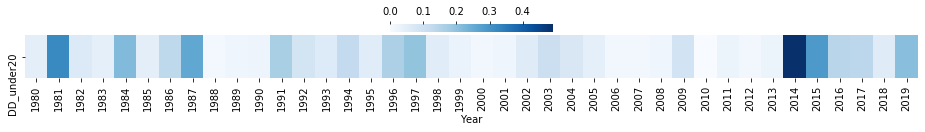

Vavau - mean degree days under 18C - tiptop months18 - 32


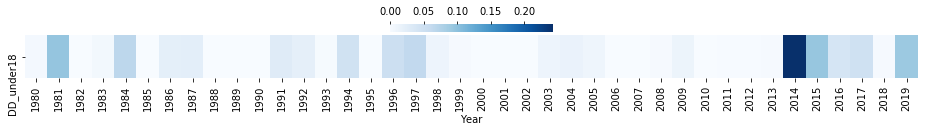

Vavau - mean minimum temperature (C) - preonset months20 - 36


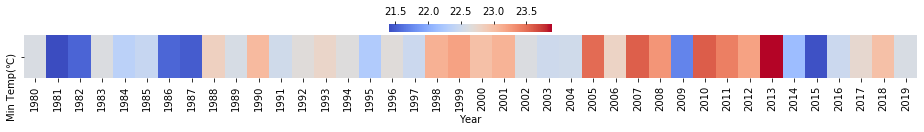

Vavau - mean maximum temperature (C) - preonset months20 - 36


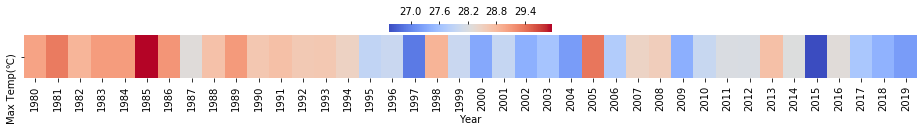

Vavau - mean weekly rainfall(mm) - preonset months20 - 36


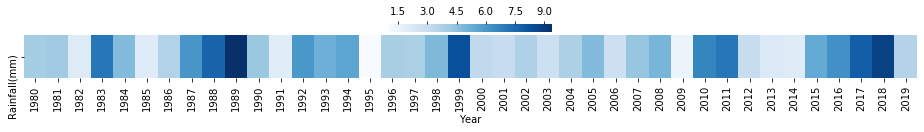

Vavau - mean temperature Spread (C) - preonset months20 - 36


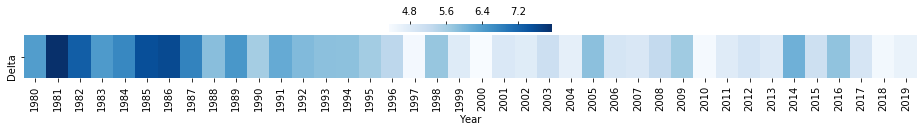

Vavau - mean degree days over 25C - preonset months20 - 36


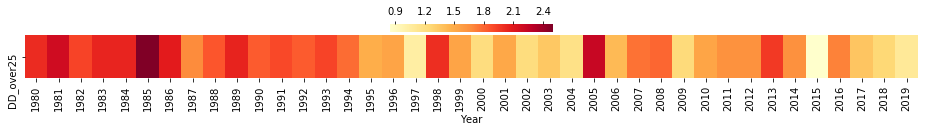

Vavau - mean degree days over 30C - preonset months20 - 36


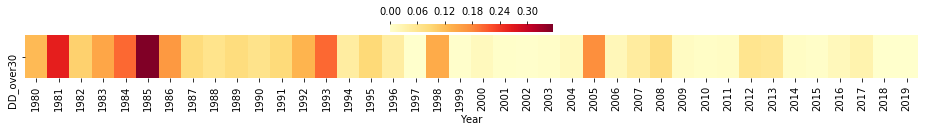

Vavau - mean degree days under 20C - preonset months20 - 36


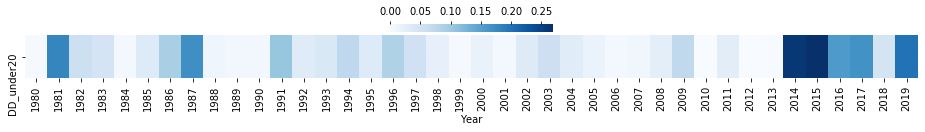

Vavau - mean degree days under 18C - preonset months20 - 36


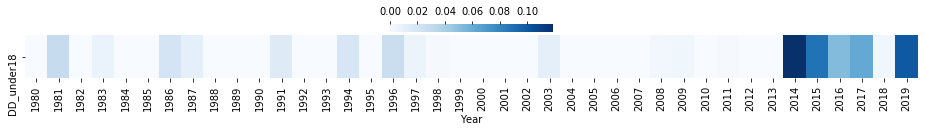

Vavau - mean minimum temperature (C) - pollination months36 - 48


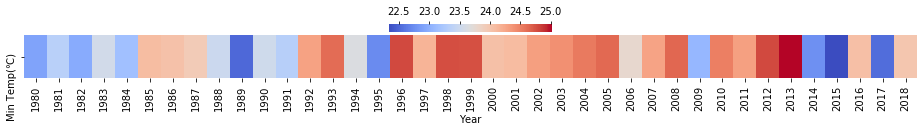

Vavau - mean maximum temperature (C) - pollination months36 - 48


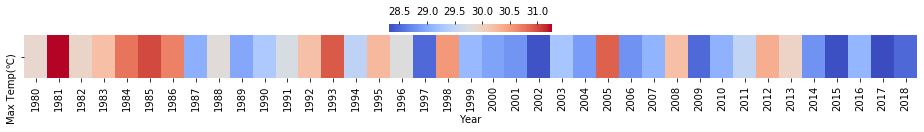

Vavau - mean weekly rainfall(mm) - pollination months36 - 48


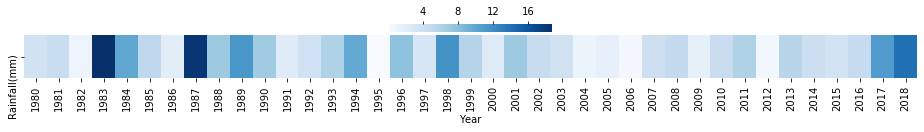

Vavau - mean temperature Spread (C) - pollination months36 - 48


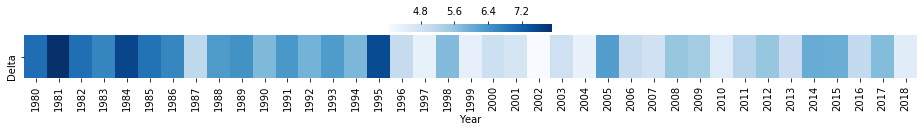

Vavau - mean degree days over 25C - pollination months36 - 48


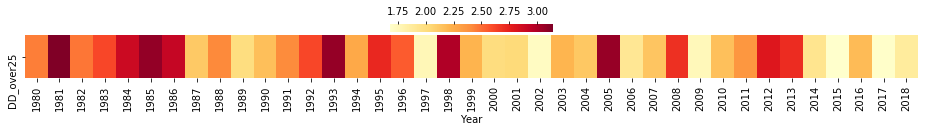

Vavau - mean degree days over 30C - pollination months36 - 48


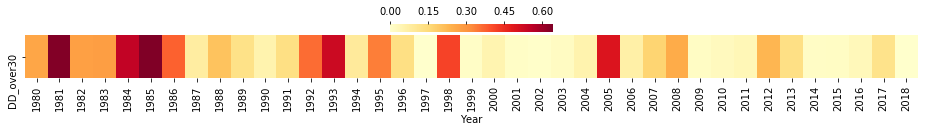

Vavau - mean degree days under 20C - pollination months36 - 48


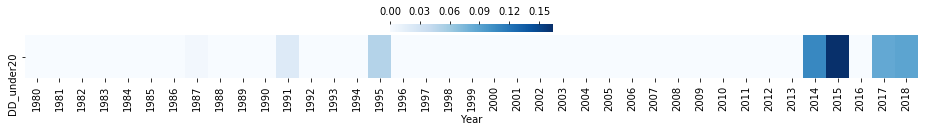

Vavau - mean degree days under 18C - pollination months36 - 48


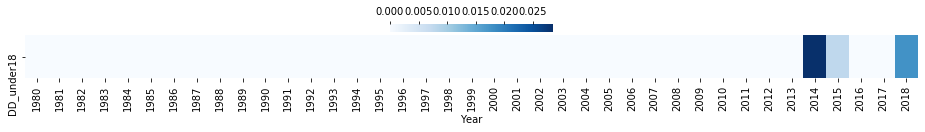

Vavau - mean minimum temperature (C) - harvest months13 - 32


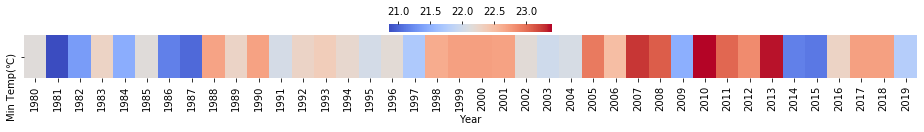

Vavau - mean maximum temperature (C) - harvest months13 - 32


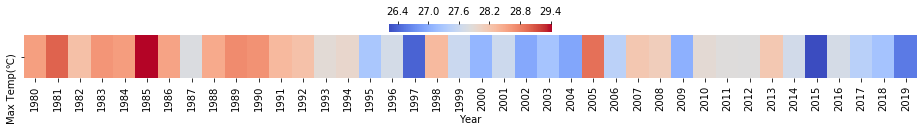

Vavau - mean weekly rainfall(mm) - harvest months13 - 32


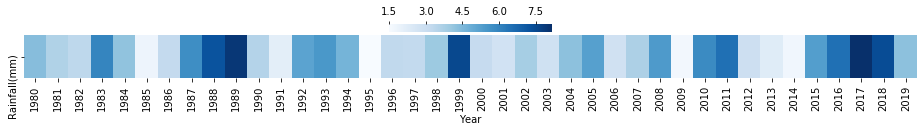

Vavau - mean temperature Spread (C) - harvest months13 - 32


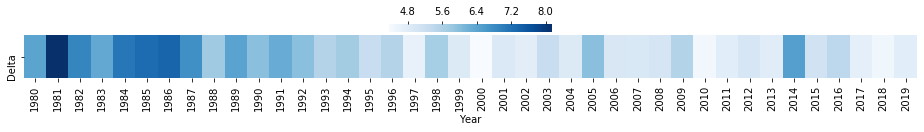

Vavau - mean degree days over 25C - harvest months13 - 32


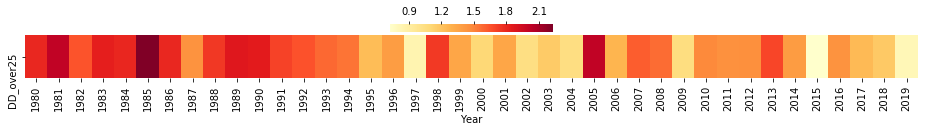

Vavau - mean degree days over 30C - harvest months13 - 32


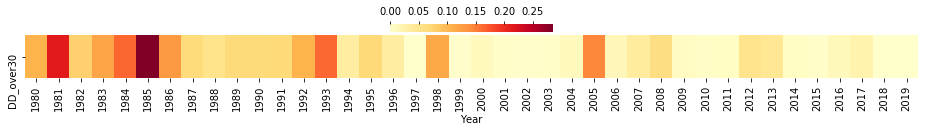

Vavau - mean degree days under 20C - harvest months13 - 32


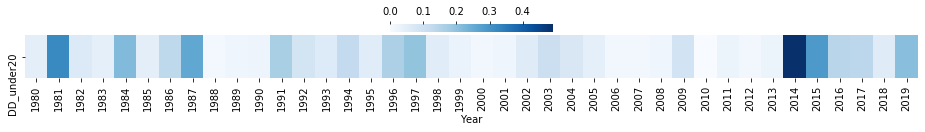

Vavau - mean degree days under 18C - harvest months13 - 32


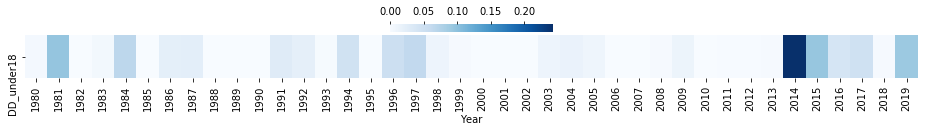

Vavau - mean minimum temperature (C) - podfill months36 - 13


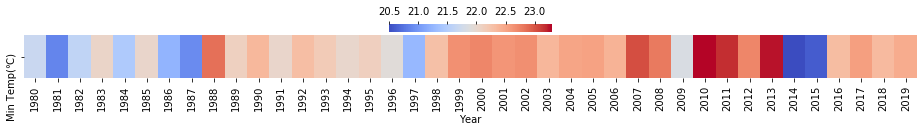

Vavau - mean maximum temperature (C) - podfill months36 - 13


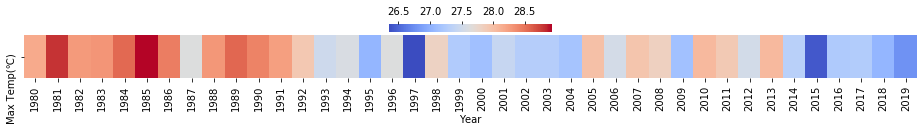

Vavau - mean weekly rainfall(mm) - podfill months36 - 13


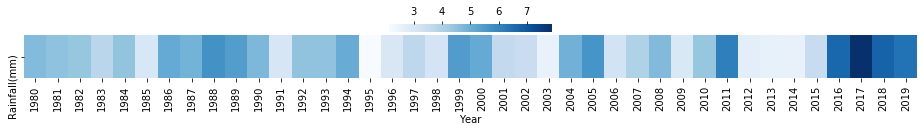

Vavau - mean temperature Spread (C) - podfill months36 - 13


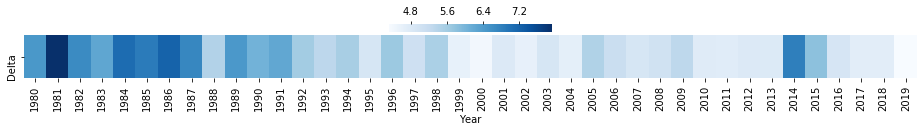

Vavau - mean degree days over 25C - podfill months36 - 13


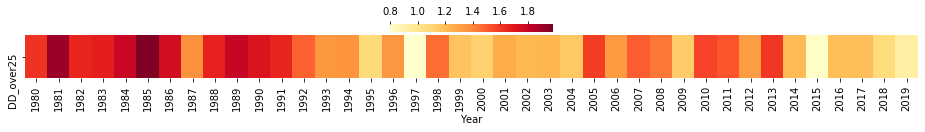

Vavau - mean degree days over 30C - podfill months36 - 13


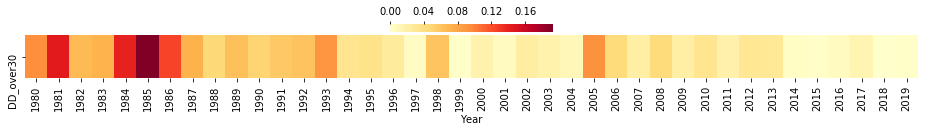

Vavau - mean degree days under 20C - podfill months36 - 13


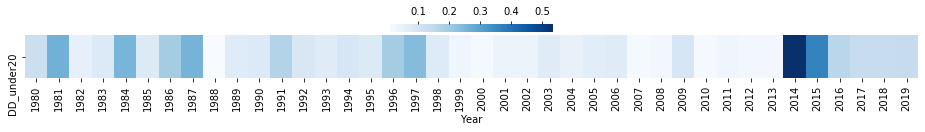

Vavau - mean degree days under 18C - podfill months36 - 13


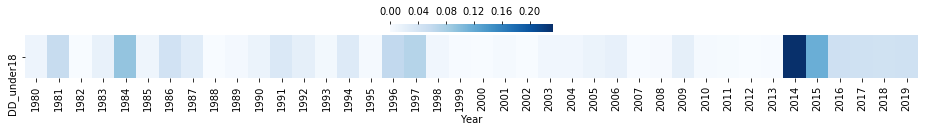

Tongatapu - mean minimum temperature (C) - tiptop months18 - 32


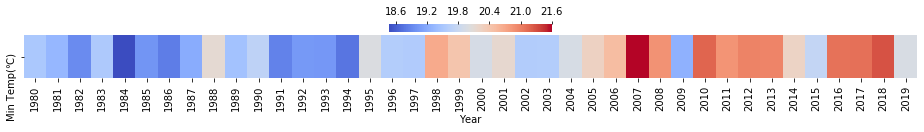

Tongatapu - mean maximum temperature (C) - tiptop months18 - 32


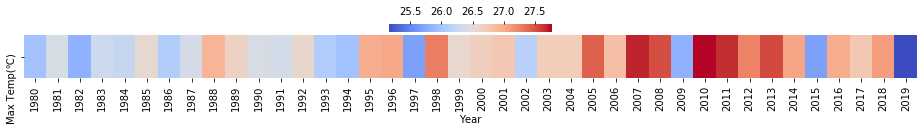

Tongatapu - mean weekly rainfall(mm) - tiptop months18 - 32


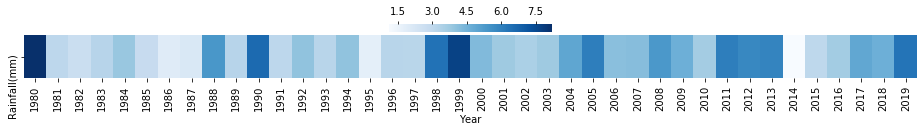

Tongatapu - mean temperature Spread (C) - tiptop months18 - 32


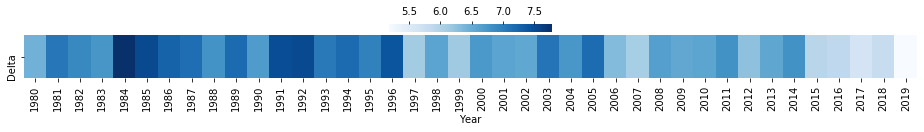

Tongatapu - mean degree days over 25C - tiptop months18 - 32


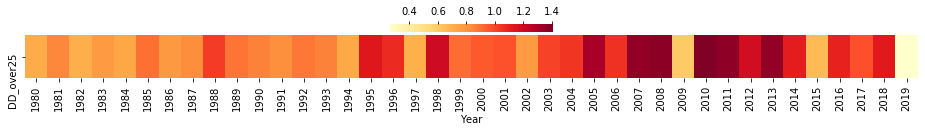

Tongatapu - mean degree days over 30C - tiptop months18 - 32


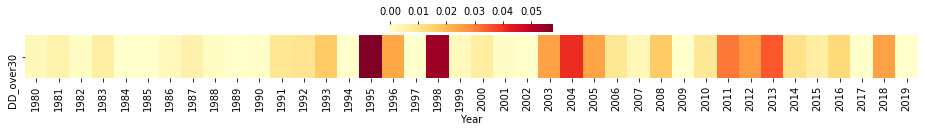

Tongatapu - mean degree days under 20C - tiptop months18 - 32


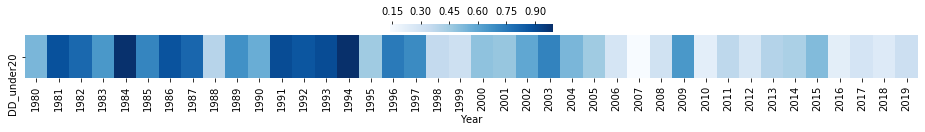

Tongatapu - mean degree days under 18C - tiptop months18 - 32


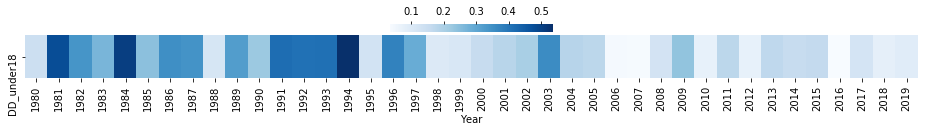

Tongatapu - mean minimum temperature (C) - preonset months20 - 36


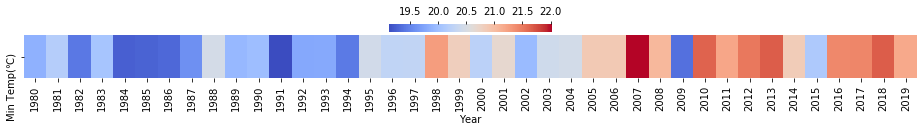

Tongatapu - mean maximum temperature (C) - preonset months20 - 36


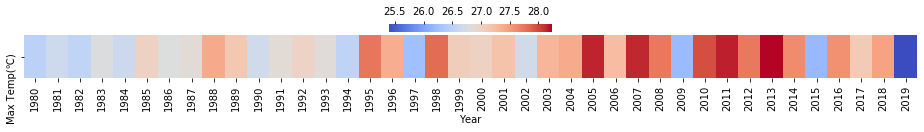

Tongatapu - mean weekly rainfall(mm) - preonset months20 - 36


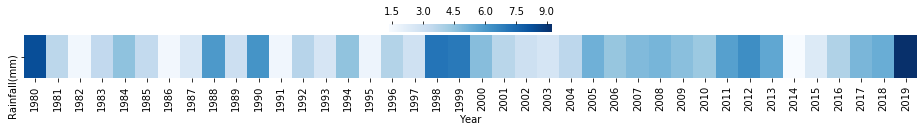

Tongatapu - mean temperature Spread (C) - preonset months20 - 36


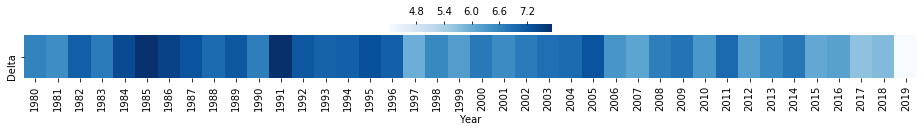

Tongatapu - mean degree days over 25C - preonset months20 - 36


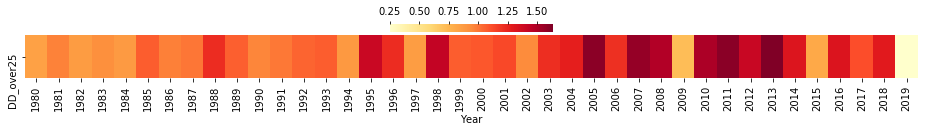

Tongatapu - mean degree days over 30C - preonset months20 - 36


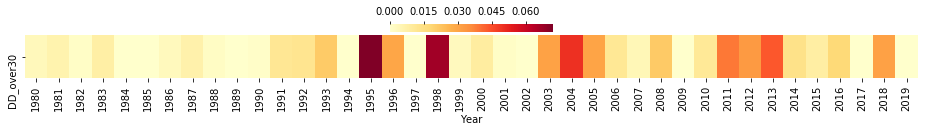

Tongatapu - mean degree days under 20C - preonset months20 - 36


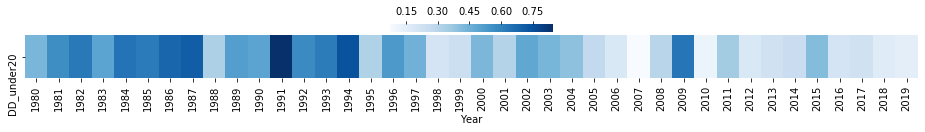

Tongatapu - mean degree days under 18C - preonset months20 - 36


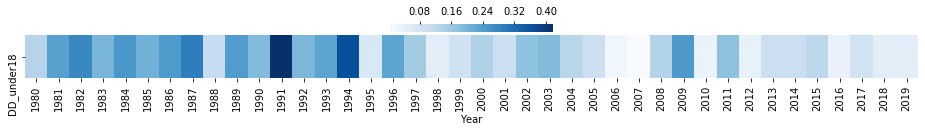

Tongatapu - mean minimum temperature (C) - pollination months36 - 48


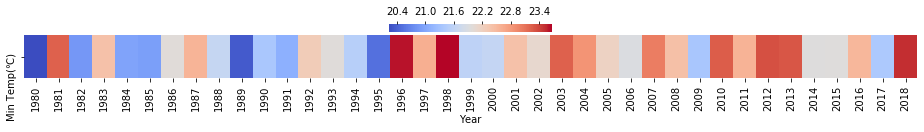

Tongatapu - mean maximum temperature (C) - pollination months36 - 48


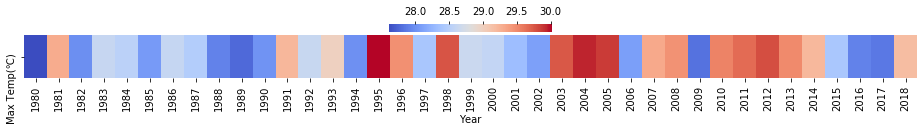

Tongatapu - mean weekly rainfall(mm) - pollination months36 - 48


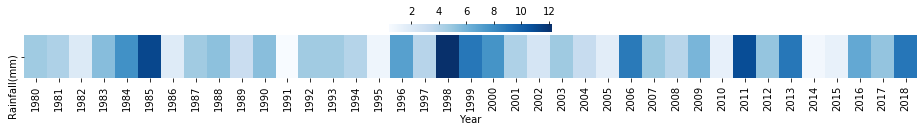

Tongatapu - mean temperature Spread (C) - pollination months36 - 48


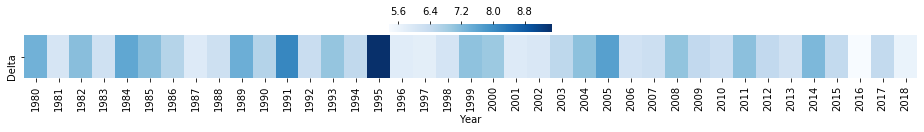

Tongatapu - mean degree days over 25C - pollination months36 - 48


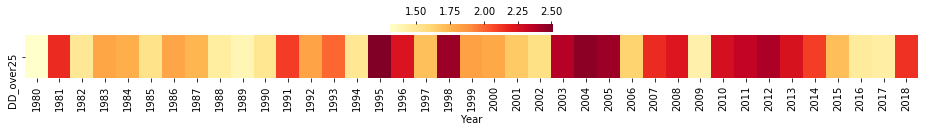

Tongatapu - mean degree days over 30C - pollination months36 - 48


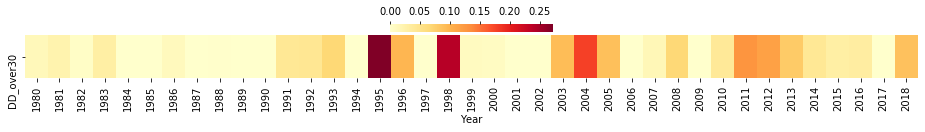

Tongatapu - mean degree days under 20C - pollination months36 - 48


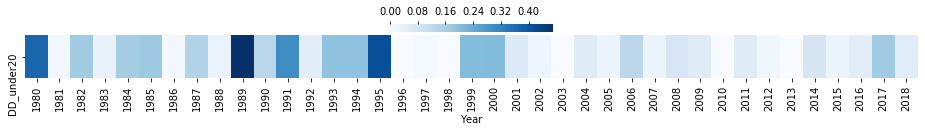

Tongatapu - mean degree days under 18C - pollination months36 - 48


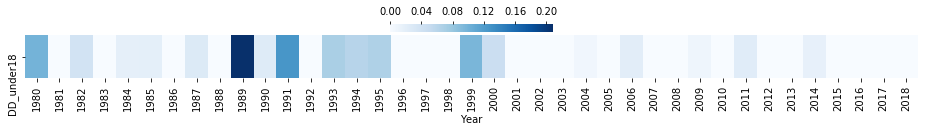

Tongatapu - mean minimum temperature (C) - harvest months13 - 32


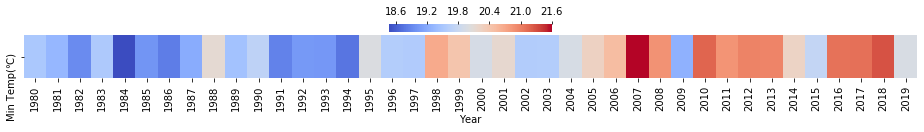

Tongatapu - mean maximum temperature (C) - harvest months13 - 32


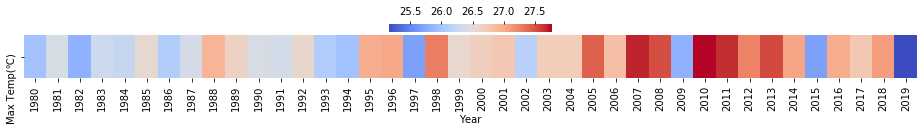

Tongatapu - mean weekly rainfall(mm) - harvest months13 - 32


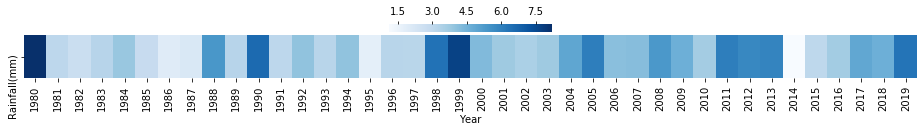

Tongatapu - mean temperature Spread (C) - harvest months13 - 32


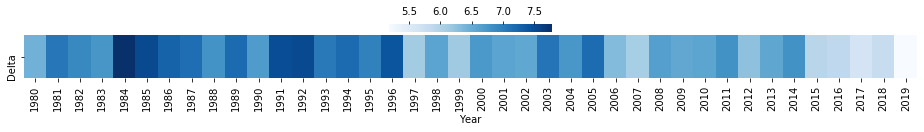

Tongatapu - mean degree days over 25C - harvest months13 - 32


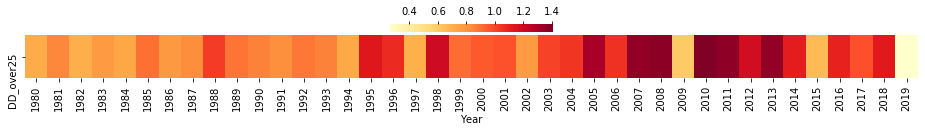

Tongatapu - mean degree days over 30C - harvest months13 - 32


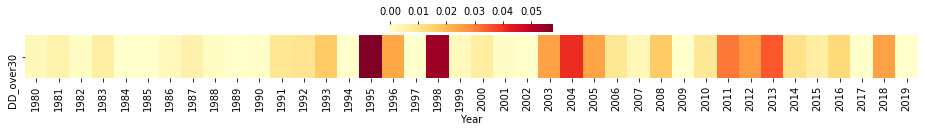

Tongatapu - mean degree days under 20C - harvest months13 - 32


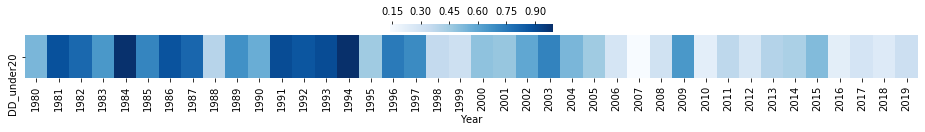

Tongatapu - mean degree days under 18C - harvest months13 - 32


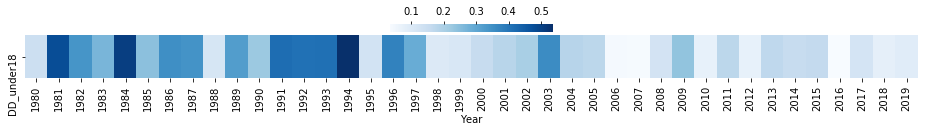

Tongatapu - mean minimum temperature (C) - podfill months36 - 13


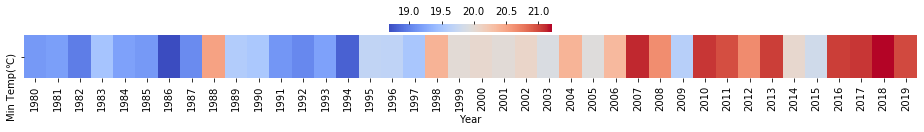

Tongatapu - mean maximum temperature (C) - podfill months36 - 13


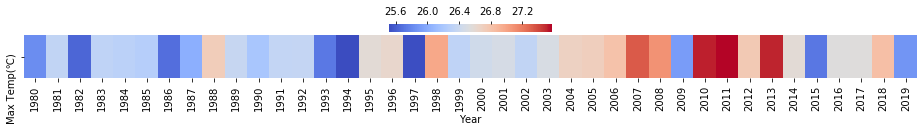

Tongatapu - mean weekly rainfall(mm) - podfill months36 - 13


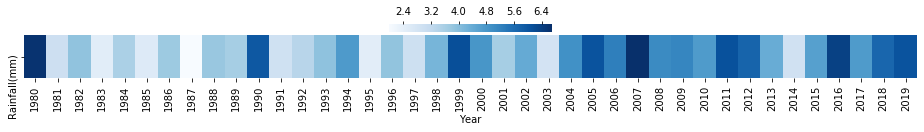

Tongatapu - mean temperature Spread (C) - podfill months36 - 13


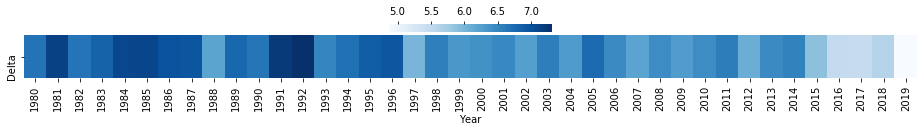

Tongatapu - mean degree days over 25C - podfill months36 - 13


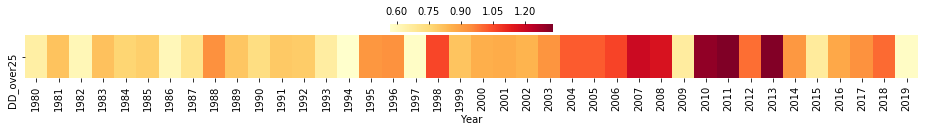

Tongatapu - mean degree days over 30C - podfill months36 - 13


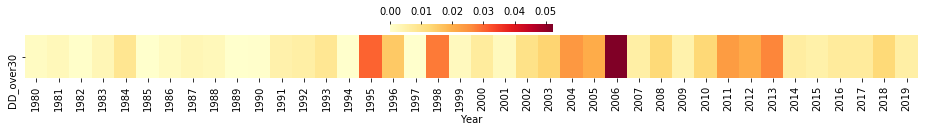

Tongatapu - mean degree days under 20C - podfill months36 - 13


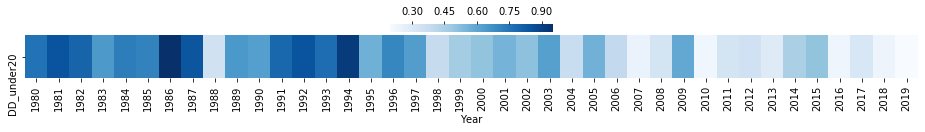

Tongatapu - mean degree days under 18C - podfill months36 - 13


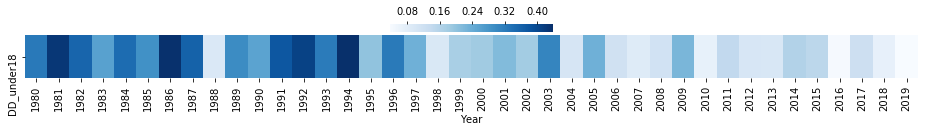

In [10]:
#Generating figures and writing to disk as PNG files
for station in station_ids.keys():
    #Read excel file into memory
    frame_root = pd.read_excel(station+'-01011980 to '+end_date_filename+'.xls', header=0).fillna(np.nan)
    #Generating heatmaps
    for phase in phases:
        lower = frame_root.Week>phases[phase][0]
        upper = frame_root.Week>phases[phase][1]
        dummy = phases[phase][2]
        d_cut = (dummy & (lower | upper)) | ((1-dummy) & (lower & upper))
        frame = frame_root[d_cut]
        for figure in figure_dict.keys():
            table_sum = pd.pivot_table(frame,columns='Year',values = figure_dict[figure]['df_column'],aggfunc=np.sum)
            table_sum.to_excel(station+' - '+figure_dict[figure]['name']+' - '+phase+'.xls')
            htmp = pd.pivot_table(frame,columns='Year',values = figure_dict[figure]['df_column'],aggfunc=np.mean)
            fig, ax = plt.subplots(figsize=(16,1))
            sns.heatmap(htmp, cmap=figure_dict[figure]['color'], cbar_kws = dict(use_gridspec=False,location="top"))
            print(station+' - '+figure_dict[figure]['name']+' - '+phase+' months'+str(phases[phase][0])+' - '+str(phases[phase][1]))
            plt.show()